<a href="https://colab.research.google.com/github/AKASH4671/AI-Powered-Portfolio-Optimization-and-Risk-Management/blob/main/4_Machine_Learning__Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [16]:
!pip install yfinance
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.cluster import KMeans

**Load Data**

In [5]:
# Load historical stock data
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "JPM", "JNJ", "XOM", "WMT", "NVDA"]
data = yf.download(tickers, start="2019-01-01", end="2024-12-31")
returns = data['Close'].pct_change().dropna()

/tmp/ipython-input-5-2325990233.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  10 of 10 completed


**standarize returns**

In [6]:
# Standardize returns
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

**PCA**

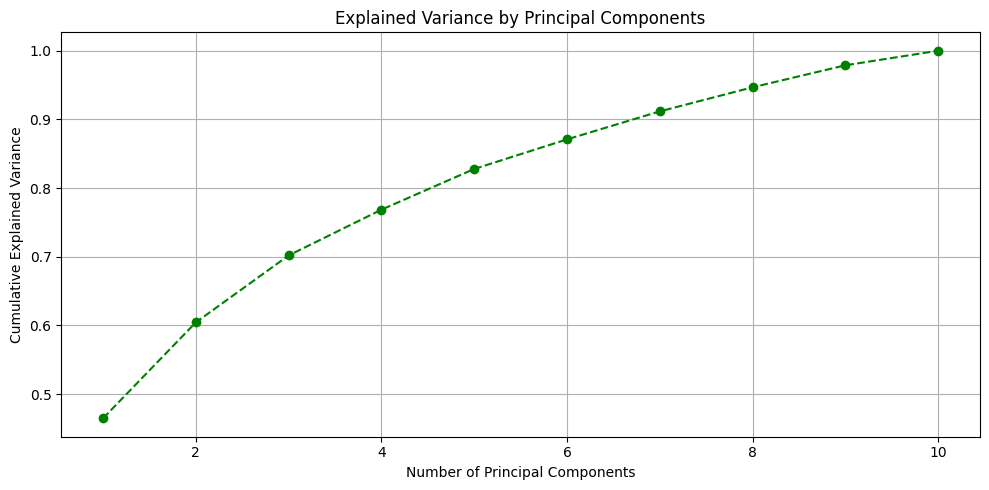

In [7]:
# PCA
pca = PCA()
pca_components = pca.fit_transform(scaled_returns)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Screen Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='green')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

**loadings from each stock on the first two principal components**

In [10]:
# Loadings for each stock on the first two principal components
loadings_df = pd.DataFrame(pca.components_.T[:, :2],  # First 2 PCs
                           index=returns.columns,
                           columns=['PC1', 'PC2'])

# Sort by PC1 to see which stocks load highest/lowest
sorted_pc1 = loadings_df.sort_values(by='PC1', ascending=False)

# Sort by PC2 to see which stocks load highest/lowest on PC2
sorted_pc2 = loadings_df.sort_values(by='PC2', ascending=False)

# Display the sorted loadings
print("Top Stocks by PC1 (likely Tech/Growth influence):")
display(sorted_pc1)

print("\nTop Stocks by PC2 (likely Value/Defensive influence):")
display(sorted_pc2)


Top Stocks by PC1 (likely Tech/Growth influence):


,PC1,PC2
Ticker,,
MSFT,0.409444,-0.119837
AAPL,0.389027,-0.076754
GOOGL,0.378598,-0.125173
AMZN,0.352125,-0.283675
NVDA,0.350461,-0.257521
JPM,0.282886,0.434755
TSLA,0.265462,-0.265222
WMT,0.224581,0.228575
JNJ,0.219219,0.478516



Top Stocks by PC2 (likely Value/Defensive influence):


,PC1,PC2
Ticker,,
XOM,0.204632,0.526034
JNJ,0.219219,0.478516
JPM,0.282886,0.434755
WMT,0.224581,0.228575
AAPL,0.389027,-0.076754
MSFT,0.409444,-0.119837
GOOGL,0.378598,-0.125173
NVDA,0.350461,-0.257521
TSLA,0.265462,-0.265222


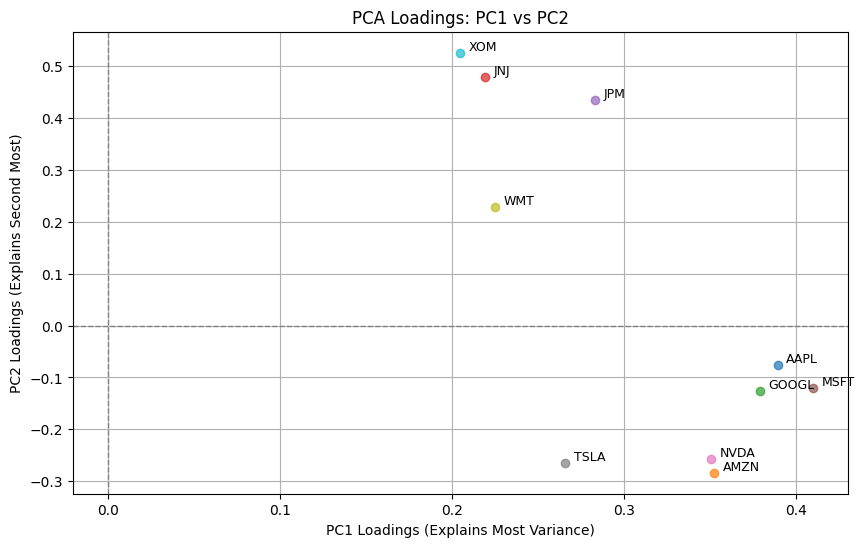

In [8]:
# Get loadings (eigenvectors)
loadings = pca.components_.T  # shape: (num_assets, num_components)
pc1_loadings = loadings[:, 0]
pc2_loadings = loadings[:, 1]

# Plotting
plt.figure(figsize=(10, 6))
for i, ticker in enumerate(returns.columns):
    plt.scatter(pc1_loadings[i], pc2_loadings[i], alpha=0.7)
    plt.text(pc1_loadings[i] + 0.005, pc2_loadings[i] + 0.005, ticker, fontsize=9)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("PCA Loadings: PC1 vs PC2")
plt.xlabel("PC1 Loadings (Explains Most Variance)")
plt.ylabel("PC2 Loadings (Explains Second Most)")
plt.grid(True)
plt.show()

**K - Means clustering**

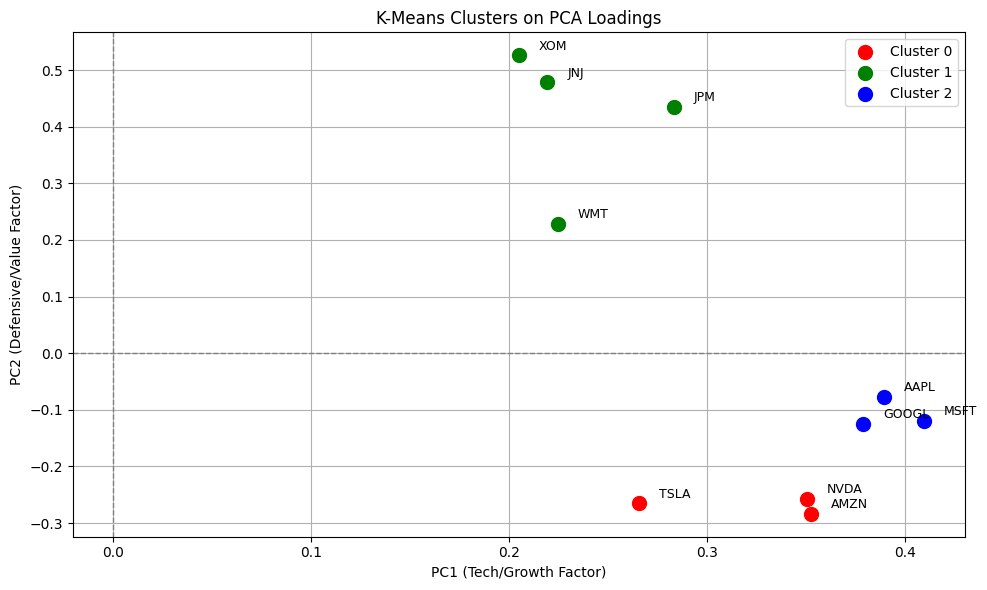

,PC1,PC2,Cluster
MSFT,0.409444,-0.119837,2
AAPL,0.389027,-0.076754,2
GOOGL,0.378598,-0.125173,2
AMZN,0.352125,-0.283675,0
NVDA,0.350461,-0.257521,0
JPM,0.282886,0.434755,1
TSLA,0.265462,-0.265222,0
WMT,0.224581,0.228575,1
JNJ,0.219219,0.478516,1
XOM,0.204632,0.526034,1


In [18]:
# Run K-Means on PC1 and PC2
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
loadings_df['Cluster'] = kmeans.fit_predict(loadings_df[['PC1', 'PC2']])

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
for i in range(3):
    cluster_data = loadings_df[loadings_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {i}', color=colors[i], s=100)
    for ticker in cluster_data.index:
        x, y = cluster_data.loc[ticker, ['PC1', 'PC2']]
        plt.text(x + 0.01, y + 0.01, ticker, fontsize=9)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("K-Means Clusters on PCA Loadings")
plt.xlabel("PC1 (Tech/Growth Factor)")
plt.ylabel("PC2 (Defensive/Value Factor)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

loadings_df[['PC1', 'PC2', 'Cluster']]


**Diversifications**

In [20]:
# Diversification: Pick 1–2 stocks per cluster
diversified_portfolio = loadings_df.groupby('Cluster').apply(lambda x: x.sample(n=2, random_state=42))

# Risk Bucketing Labels
cluster_labels = {0: 'Growth', 1: 'Defensive', 2: 'Core'}
loadings_df['Risk_Bucket'] = loadings_df['Cluster'].map(cluster_labels)

# Portfolio Optimization: Penalize cluster overexposure
# Here: We simulate equal allocation, then count allocation per cluster
equal_weights = 1 / len(loadings_df)
loadings_df['Weight'] = equal_weights
cluster_exposure = loadings_df.groupby('Cluster')['Weight'].sum()

# Auto-weighted Portfolios using PC1 Loadings (normalize PC1 weights)
loadings_df['PC1_Weight'] = loadings_df['PC1'] / loadings_df['PC1'].sum()

# ✅ Cluster-Based Equal Weights (Equal weight within each cluster)
cluster_counts = loadings_df.groupby('Cluster').size()
loadings_df['Cluster_Equal_Weight'] = loadings_df.apply(lambda row: 1 / cluster_counts[row.Cluster], axis=1)

# Return prepared dataframes for visualization or next steps
diversified_portfolio_display = diversified_portfolio[['PC1', 'PC2', 'Cluster']]
bucketed_df_display = loadings_df[['PC1', 'PC2', 'Cluster', 'Risk_Bucket', 'Weight', 'PC1_Weight', 'Cluster_Equal_Weight']]
cluster_exposure_display = cluster_exposure.reset_index(name='Exposure')

diversified_portfolio_display, bucketed_df_display, cluster_exposure_display

/tmp/ipython-input-20-3524617476.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diversified_portfolio = loadings_df.groupby('Cluster').apply(lambda x: x.sample(n=2, random_state=42))


(                   PC1       PC2  Cluster
 Cluster                                  
 0       AMZN  0.352125 -0.283675        0
         NVDA  0.350461 -0.257521        0
 1       WMT   0.224581  0.228575        1
         XOM   0.204632  0.526034        1
 2       MSFT  0.409444 -0.119837        2
         AAPL  0.389027 -0.076754        2,
             PC1       PC2  Cluster Risk_Bucket  Weight  PC1_Weight  \
 MSFT   0.409444 -0.119837        2        Core     0.1    0.133090   
 AAPL   0.389027 -0.076754        2        Core     0.1    0.126454   
 GOOGL  0.378598 -0.125173        2        Core     0.1    0.123064   
 AMZN   0.352125 -0.283675        0      Growth     0.1    0.114459   
 NVDA   0.350461 -0.257521        0      Growth     0.1    0.113918   
 JPM    0.282886  0.434755        1   Defensive     0.1    0.091953   
 TSLA   0.265462 -0.265222        0      Growth     0.1    0.086289   
 WMT    0.224581  0.228575        1   Defensive     0.1    0.073000   
 JNJ    0.219219

**Stock Risk Buckets and Weighting Schemes**

In [25]:
display(bucketed_df_display)

,PC1,PC2,Cluster,Risk_Bucket,Weight,PC1_Weight,Cluster_Equal_Weight
MSFT,0.409444,-0.119837,2,Core,0.1,0.133090,0.333333
AAPL,0.389027,-0.076754,2,Core,0.1,0.126454,0.333333
GOOGL,0.378598,-0.125173,2,Core,0.1,0.123064,0.333333
AMZN,0.352125,-0.283675,0,Growth,0.1,0.114459,0.333333
NVDA,0.350461,-0.257521,0,Growth,0.1,0.113918,0.333333
JPM,0.282886,0.434755,1,Defensive,0.1,0.091953,0.250000
TSLA,0.265462,-0.265222,0,Growth,0.1,0.086289,0.333333
WMT,0.224581,0.228575,1,Defensive,0.1,0.073000,0.250000
JNJ,0.219219,0.478516,1,Defensive,0.1,0.071257,0.250000
XOM,0.204632,0.526034,1,Defensive,0.1,0.066516,0.250000


**Cluster Exposure in Equal-Weighted Portfolio & plot**

In [23]:
display(cluster_exposure_display)

,Cluster,Exposure
0,0,0.3
1,1,0.4
2,2,0.3


/tmp/ipython-input-24-1018502355.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Exposure', data=cluster_exposure_display, palette='viridis')


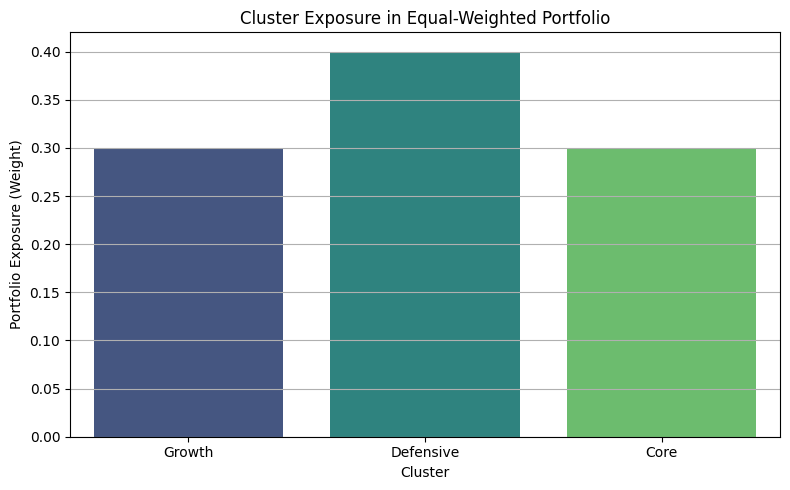

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='Exposure', data=cluster_exposure_display, palette='viridis')
plt.title('Cluster Exposure in Equal-Weighted Portfolio')
plt.xlabel('Cluster')
plt.ylabel('Portfolio Exposure (Weight)')
plt.xticks(ticks=cluster_exposure_display['Cluster'], labels=cluster_exposure_display['Cluster'].map(cluster_labels))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**save all 3 portfolio's**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [29]:
# Save location
save_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Powered-Portfolio-Optimization-and-Risk-Management/data/' # Added trailing slash

### 1. Naive Equal Weighted Portfolio
equal_portfolio = pd.DataFrame({
    'Ticker': loadings_df.index,
    'Weight': 1 / len(loadings_df)
})
equal_portfolio.to_csv(save_path + 'portfolio_equal_weight.csv', index=False)

### 2️. Cluster Diversified Portfolio (2 stocks per cluster)
loadings_df['Ticker'] = loadings_df.index

# Sample 2 from each cluster
diversified_portfolio = loadings_df.groupby('Cluster').apply(lambda x: x.sample(n=2, random_state=42)).reset_index(drop=True)
diversified_portfolio_df = diversified_portfolio[['Ticker']].copy()
diversified_portfolio_df['Weight'] = 1 / len(diversified_portfolio_df)
diversified_portfolio_df.to_csv(save_path + 'portfolio_cluster_diversified.csv', index=False)

### 3️. PCA Weighted Portfolio (based on PC1)
pca_weighted_portfolio = loadings_df[['PC1']].copy()
pca_weighted_portfolio['Ticker'] = loadings_df.index
pca_weighted_portfolio['Weight'] = pca_weighted_portfolio['PC1'] / pca_weighted_portfolio['PC1'].sum()
pca_weighted_portfolio = pca_weighted_portfolio[['Ticker', 'Weight']]
pca_weighted_portfolio.to_csv(save_path + 'portfolio_pca_weighted.csv', index=False)

print("All 3 portfolios saved.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All 3 portfolios saved.


/tmp/ipython-input-29-4219370041.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diversified_portfolio = loadings_df.groupby('Cluster').apply(lambda x: x.sample(n=2, random_state=42)).reset_index(drop=True)
